In [79]:
import pandas as pd
import datetime
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_absolute_per_error(y_p, y_t):
    return np.mean(np.abs(y_p - y_t) / y_t)
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(20,10))

train = pd.read_csv("/home/zhli7/20160405.csv", names=["timestamp","node_pair","link","speed_x","count","type","status_x","timestamp_y","status_y","speed","mapped_status"], parse_dates=["timestamp"], index_col="timestamp")
test = pd.read_csv("/home/zhli7/20160406.csv", names=["timestamp","node_pair","link","speed_x","count","type","status_x","timestamp_y","status_y","speed","mapped_status"], parse_dates=["timestamp"], index_col="timestamp")

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


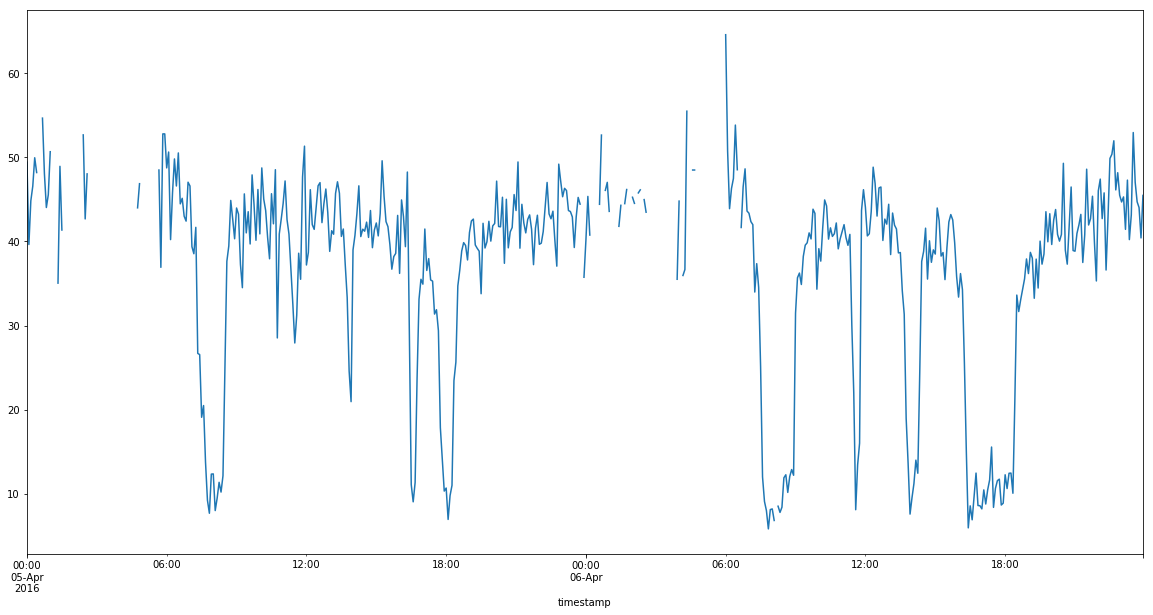

In [80]:
link = 14718608
data = pd.concat([train, test], axis=0)
sample = data[data['link']==link]['speed'].resample('5min')
sample.plot()
# train[train['link']==14718608]['speed'].resample('5min').plot()
# test[test['link']==14718608]['speed'].resample('5min').plot()

In [81]:
dataset = []
dataset_time_index = []
weather = {'2014-08-03': 0, '2014-08-04': 1, '2014-08-05': 1, '2014-08-06': 1, '2014-08-07': 1, '2014-08-08': 1, '2014-08-09': 1, '2014-08-10': 1, '2014-08-11': 0, '2014-08-12': 0, '2014-08-13': 0, '2014-08-14': 0, '2014-08-15': 1, '2014-08-16': 1, '2014-08-17': 0, '2014-08-18': 0, '2014-08-19': 0, '2014-08-20': 1, '2014-08-21': 1, '2014-08-22': 1, '2014-08-23': 0, '2014-08-24': 0, '2014-08-25': 1, '2014-08-26': 1, '2014-08-27': 0, '2014-08-28': 0, '2014-08-29': 0, '2014-08-30': 0}
for (t, s) in sample.iteritems():
    speed = s
    if t.hour > 5:
        if math.isnan(s):
            speed = dataset[-1][0]
#         day_feature = [1 if i == t.isoweekday() else 0 for i in range(1,8)] + [t.hour, t.minute]
#         day_feature = [t.isoweekday(), t.hour, t.minute, 1 if t.isoweekday() in [6,7] else 0]
#         day_feature = [t.isoweekday()]
        day_feature = []
#         feature = [speed, weather[t.strftime('%Y-%m-%d')]] + day_feature
        feature = [speed] + day_feature
        dataset.append(feature)
        dataset_time_index.append(t)
                   
dataset = np.array(dataset)

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 
.resample() is now a deferred operation
You called iteritems(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


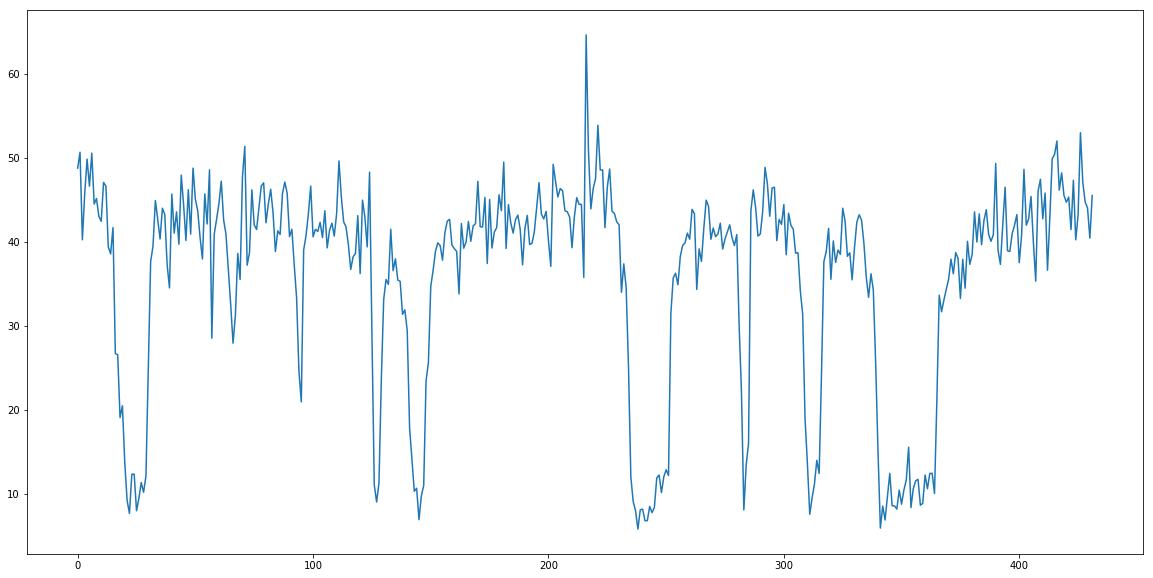

In [82]:
plt.plot(dataset[:, 0])

In [83]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset[:, 0] = scaler.fit_transform(dataset[:, 0])

/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [84]:
train_size = len(dataset) * 0.6
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

(259, 173)


/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [85]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [95]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [96]:
from keras.regularizers import l2, activity_l2
hidden_neurons = 500
loss_function = 'mse'
batch_size = 20
dropout = 0.056
inner_hidden_neurons = 458
dropout_inner = 0.12
out_neurons = 1
model = Sequential()
# model.add(LSTM(4, batch_input_shape=(batch_size, look_back, trainX.shape[2]), activation='tanh', dropout_U=0.05, stateful=True, return_sequences=True))
# model.add(LSTM(8, batch_input_shape=(batch_size, look_back, trainX.shape[2]), activation='tanh', dropout_U=0.05, stateful=True))
# model.add(Dense(1))
# for i in range(100):
#     model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
#     model.reset_states()
in_neurons = trainX.shape[2]
gpu_cpu = 'cpu'
model.add(LSTM(output_dim=hidden_neurons, input_dim=in_neurons, return_sequences=True, init='uniform',
                   consume_less=gpu_cpu))
model.add(Dropout(dropout))

dense_input = inner_hidden_neurons
model.add(LSTM(output_dim=inner_hidden_neurons, input_dim=hidden_neurons, return_sequences=True, consume_less=gpu_cpu))
model.add(Dropout(dropout_inner))
model.add(LSTM(input_dim=inner_hidden_neurons, output_dim=dense_input, return_sequences=False))
model.add(Dropout(dropout_inner))
model.add(Activation('relu'))

model.add(Dense(output_dim=out_neurons, input_dim=dense_input))
model.add(Activation('relu'))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=batch_size, verbose=2, shuffle=False)



Epoch 1/100
5s - loss: 0.2445
Epoch 2/100
4s - loss: 0.0381
Epoch 3/100
5s - loss: 0.0256
Epoch 4/100
5s - loss: 0.0170
Epoch 5/100
4s - loss: 0.0146
Epoch 6/100
4s - loss: 0.0125
Epoch 7/100
4s - loss: 0.0106
Epoch 8/100
6s - loss: 0.0098
Epoch 9/100
5s - loss: 0.0093
Epoch 10/100
5s - loss: 0.0096
Epoch 11/100
4s - loss: 0.0094
Epoch 12/100
3s - loss: 0.0096
Epoch 13/100
6s - loss: 0.0095
Epoch 14/100
4s - loss: 0.0095
Epoch 15/100
4s - loss: 0.0095
Epoch 16/100
6s - loss: 0.0092
Epoch 17/100
5s - loss: 0.0090
Epoch 18/100
4s - loss: 0.0092
Epoch 19/100
4s - loss: 0.0091
Epoch 20/100
5s - loss: 0.0091
Epoch 21/100
7s - loss: 0.0095
Epoch 22/100
5s - loss: 0.0092
Epoch 23/100
6s - loss: 0.0091
Epoch 24/100
5s - loss: 0.0087
Epoch 25/100
6s - loss: 0.0088
Epoch 26/100
7s - loss: 0.0094
Epoch 27/100
4s - loss: 0.0083
Epoch 28/100
4s - loss: 0.0090
Epoch 29/100
6s - loss: 0.0088
Epoch 30/100
6s - loss: 0.0088
Epoch 31/100
9s - loss: 0.0086
Epoch 32/100
7s - loss: 0.0089
Epoch 33/100
11s 

In [97]:
trainPredict = model.predict(trainX, batch_size=batch_size)
# model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = mean_absolute_per_error(trainPredict[:, 0], trainY)
print('Train Score: %.2f MAPE' % (trainScore))
days = 5
testScore = mean_absolute_per_error(testPredict[0:36*days, 0], testY[0:36*days])
print('Test Score %.2f MAPE' % (testScore))

Train Score: 0.13 MAPE
Test Score 0.15 MAPE


/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(432,)
(432,)


/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


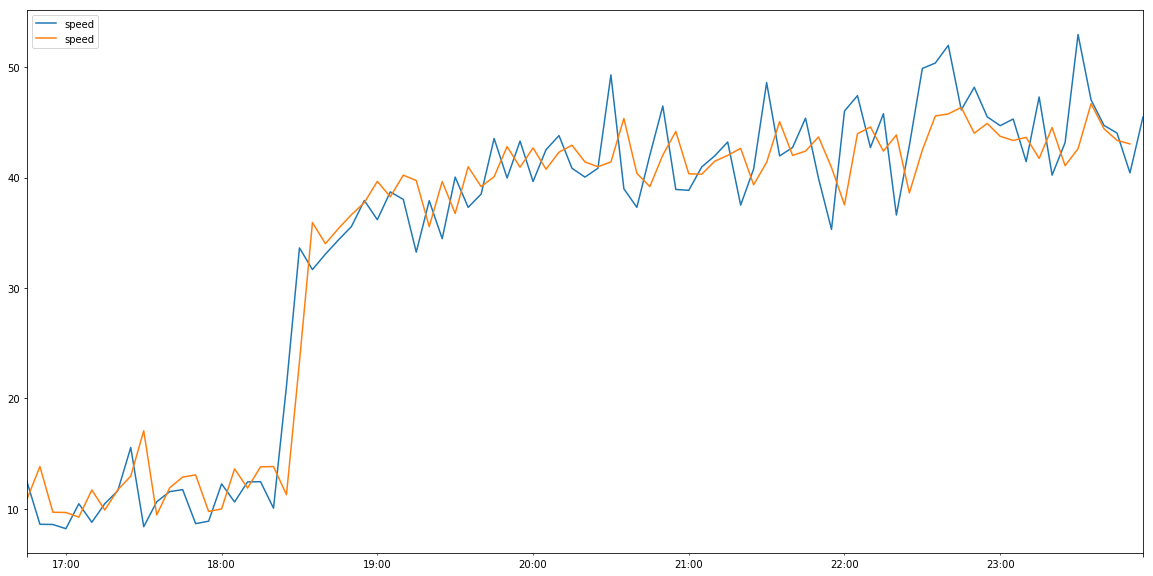

In [98]:
import numpy
trainPredictPlot = numpy.empty_like(dataset[:, 0])
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:, 0]

testPredictPlot = numpy.empty_like(dataset[:, 0])
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict[:, 0]

print trainPredictPlot.shape
print testPredictPlot.shape
start = int(len(dataset) * 0.8)
end = len(dataset)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# ax.plot(scaler.inverse_transform(dataset[start:, 0]))
# ax.plot(trainPredictPlot[start:])
# ax.plot(testPredictPlot[start:])
# ax.set_xticks(dataset_time_index[start:])
pd.DataFrame(scaler.inverse_transform(dataset[start:end, 0]), index=dataset_time_index[start:end], columns=['speed']).plot(ax=ax)
pd.DataFrame(testPredictPlot[start:end], index=dataset_time_index[start:end], columns=['speed']).plot(ax=ax)